In [ ]:
!pip install fastf1
!pip install scikit-learn
!pip install pandas
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 2.0 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.2-cp312-cp312-linux_x86_64.whl size=15820 sha256=b9a0d5e36b926972f17e8e94d39663290c80c8b42b2138af980dc4ca38727c08
  Stored in directory: /root/.cache/pip/wheels/67/a6/40/eda0983e595bbf3841af96dbff2340be72dfac96796fc3d578
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.2
    Uninstalling msgpack-1.1.2:
      Successfully uninstalled msgpack-1.1.2
  Attempting uninstall: websocket

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import os

# Enable FastF1 caching
cache_dir = "f1_cache"
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

# Load FastF1 2025 Australian GP race session
session_2025 = fastf1.get_session(2025, 1, "R") #AUS is the 1st race
session_2025.load()

# Extract lap times
laps_2025 = session_2025.laps[["Driver", "LapTime"]].copy()
laps_2025.dropna(subset=["LapTime"], inplace=True)
laps_2025["LapTime (s)"] = laps_2025["LapTime"].dt.total_seconds()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_st

In [ ]:
# 2026 Qualifying Data (in seconds) - value is just placeholder
qualifying_2026 = pd.DataFrame({
    "Driver": ["Lando Norris", "Oscar Piastri", "Max Verstappen", "George Russell", "Yuki Tsunoda",
               "Alexander Albon", "Charles Leclerc", "Lewis Hamilton", "Pierre Gasly", "Carlos Sainz", "Fernando Alonso", "Lance Stroll"],
    "QualifyingTime (s)": [75.096, 75.180, 75.481, 75.546, 75.670,
                           75.737, 75.755, 75.973, 75.980, 76.062, 76.4, 76.5]
})

# Map full names to FastF1 3-letter codes
driver_mapping = {
    "Lando Norris": "NOR", "Oscar Piastri": "PIA", "Max Verstappen": "VER", "George Russell": "RUS",
    "Yuki Tsunoda": "TSU", "Alexander Albon": "ALB", "Charles Leclerc": "LEC", "Lewis Hamilton": "HAM",
    "Pierre Gasly": "GAS", "Carlos Sainz": "SAI", "Lance Stroll": "STR", "Fernando Alonso": "ALO"
}

qualifying_2026["DriverCode"] = qualifying_2026["Driver"].map(driver_mapping)

# Merge 2026 Qualifying Data with 2025 Race Data
merged_data = qualifying_2026.merge(laps_2025, left_on="DriverCode", right_on="Driver")

# Use only "QualifyingTime (s)" as a feature
X = merged_data[["QualifyingTime (s)"]]
y = merged_data["LapTime (s)"]

if X.shape[0] == 0:
    raise ValueError("Dataset is empty after preprocessing. Check data sources!")

# Train Gradient Boosting Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=39)
model.fit(X_train, y_train)

# Predict using 2026 qualifying times
predicted_lap_times = model.predict(qualifying_2026[["QualifyingTime (s)"]])
qualifying_2026["PredictedRaceTime (s)"] = predicted_lap_times

# Rank drivers by predicted race time
qualifying_2026 = qualifying_2026.sort_values(by="PredictedRaceTime (s)")

# Print final predictions
print("\n🏁 Predicted 2026 AUS GP Winner 🏁\n")
print(qualifying_2026[["Driver", "PredictedRaceTime (s)"]])

# Evaluate Model
y_pred = model.predict(X_test)
print(f"\n🔍 Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2026 AUS GP Winner 🏁

             Driver  PredictedRaceTime (s)
10  Fernando Alonso              99.331230
1     Oscar Piastri              99.369652
4      Yuki Tsunoda             102.676501
3    George Russell             103.121285
2    Max Verstappen             103.223624
8      Pierre Gasly             103.439586
9      Carlos Sainz             103.439586
6   Charles Leclerc             104.693240
11     Lance Stroll             104.998166
7    Lewis Hamilton             105.291111
0      Lando Norris             105.344617
5   Alexander Albon             107.297382

🔍 Model Error (MAE): 16.49 seconds


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta

import fastf1
import fastf1.plotting
from fastf1.core import Laps

In [ ]:
# Enable Matplotlib patches for plotting timedelta values
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None)

/tmp/ipython-input-560798311.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', num_drivers)


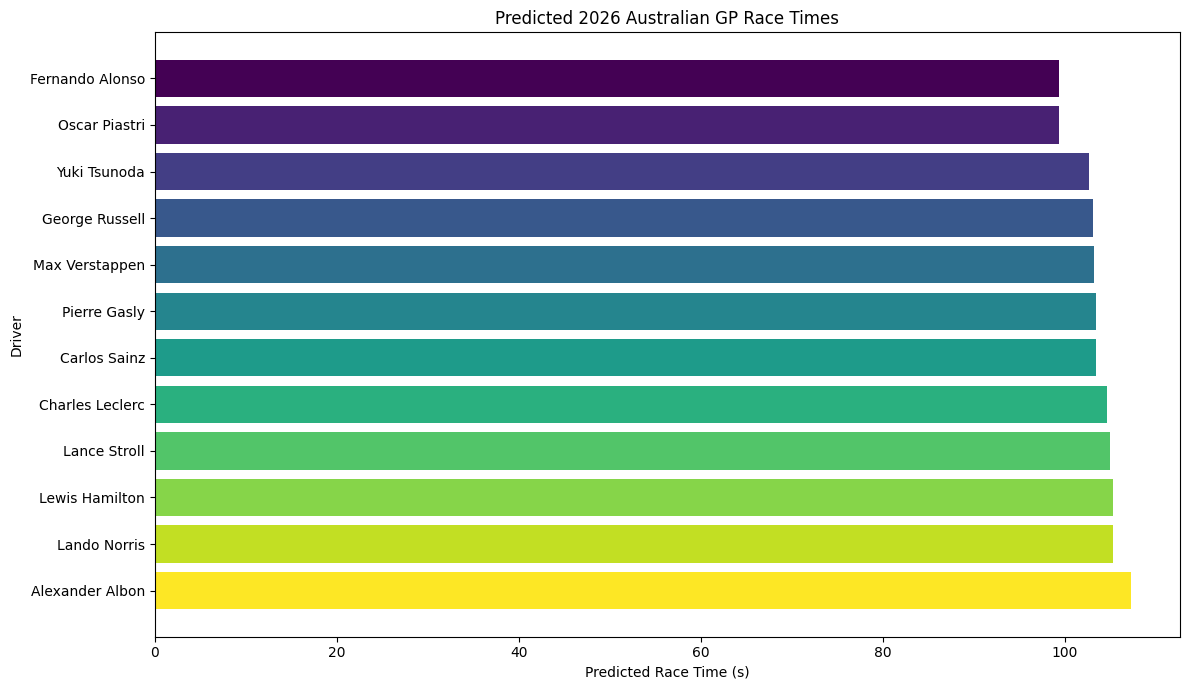

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color map for drivers
num_drivers = len(qualifying_2026['Driver'])
colors = cm.get_cmap('viridis', num_drivers)

# Create a horizontal bar chart of predicted race times with unique colors for each driver
plt.figure(figsize=(12, 7))
plt.barh(qualifying_2026['Driver'], qualifying_2026['PredictedRaceTime (s)'], color=colors(np.arange(num_drivers)))
plt.xlabel('Predicted Race Time (s)')
plt.ylabel('Driver')
plt.title('Predicted 2026 Australian GP Race Times')
plt.yticks(rotation=0)
plt.gca().invert_yaxis() # Invert y-axis to have fastest driver at the top
plt.tight_layout()
plt.show()